# Monte Carlo Metropolis Simulation of 2D Ising Model

1. From the old configuration create a new one
$$
r^{N \cdot N}_{old} \rightarrow r^{N \cdot N}_{new} 
$$

2. The new configuration is accepted with probability
$$
P = \min \left\{ 1, \exp \left( -\frac{\Delta E}{kT} \right)\right\}
$$

3. If the new configuration is not accepted, we keep the old one.

4. Repeat step 1 using the new configuration.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit
import random

### Helper Array for Accesing Neighbours

In [2]:
neigh = [[-1, 0, 1, 0],
         [0, -1, 0, 1]]

### Plotting Functions

In [16]:
def plot(val_avg, val_avg2, T, label):
    fig, ax = plt.subplots()
    ax.scatter(T, val_avg)
    val_err = np.sqrt(val_avg2 - val_avg**2)
    # ax.errorbar(T, val_avg, yerr=val_err)
    ax.set_ylabel(label)
    ax.set_xlabel("Temperature")

In [26]:
def plot_err(val_avg, val_avg2, T, label):
    fig, ax = plt.subplots()
    # ax.scatter(T, val_avg)
    val_err = np.sqrt(val_avg2 - val_avg**2)
    ax.errorbar(T, val_avg, yerr=val_err)
    ax.set_ylabel(label)
    ax.set_xlabel("Temperature")

In [4]:
def plot_grid(grid):    
    fig, ax = plt.subplots()
    
    x = np.arange(len(grid))
    y = np.arange(len(grid))

    c = ax.pcolormesh(x, y, grid, cmap="magma",
                linewidth=0, rasterized=True)

### Total Energy
$$
E = \sum_{i} E_i,
$$
$$
E_i = -\frac{J}{2} \sum_{j \in neigh(i)} S_i S_j - H S_i
$$

In [5]:
def calc_energy(grid):
    E = 0
    # Traverse all grid
    for i in range(len(grid)):
        for j in range(len(grid)):
            E -= H * grid[i][j]
            
            # Traverse all neighbors (periodic bc)
            for k in range(4):
                x = (neigh[0][k] + i) % n
                y = (neigh[1][k] + j) % n
                E -= J / 2 * grid[i][j] * grid[x][y]
    return E

### Magnetization
$$
\mu = \frac{\sum_i S_i}{N}
$$
Though here we just return $\sum_i S_i$, we will divide by N later.

In [6]:
def calc_magnetization(grid):
    return np.sum(grid)

### Susceptibility
$$
\chi = \frac{\mu}{H}
$$

In [7]:
def calc_susceptibility(grid):
    return calc_magnetization(grid) / H

### Monte Carlo Algorithm

In [8]:
def init(n):
    grid = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            grid[i][j] = 1 if random.random() < 0.5 else -1
            
    return grid

#### Change in Energy
$
\begin{align}
\Delta E &= \Delta E_i + \sum_{j \in neigh(i)} \Delta E_j \\
         &= - \frac{J}{2} \left\{ \sum_{j \in neigh(i)} \left( 
                                   S_i^{new} - S_i^{old} \right)S_j \right\}
                                   - H \left( S_i^{new} - S_i^{old} \right)
                                    -\frac{J}{2} \left\{ \sum_{j \in neigh(i)} \left( 
                                   S_i^{new} - S_i^{old} \right)S_j \right\} \\
          &= - J \Delta S_i \sum_{j \in neigh(i)} S_j -
                                              H \Delta S_i
\end{align}
$

In [9]:
# Monte Carlo Step
def mc_step(grid, mc_changes, inv_T):
    n = len(grid)
    for it in range(mc_changes):
        cell = int(random.random() * n**2)
        i = int(cell / n)
        j = int(cell % n)

        # deltaS_ij = S_ij^new - S_ji^old
        deltaS_ij = - grid[i][j] * 2
        # delta_E = 0
        delta_E   = - H * deltaS_ij

        # Traverse all neighbors
        for k in range(4):
            x = (neigh[0][k] + i) % n
            y = (neigh[1][k] + j) % n
            delta_E += - J * deltaS_ij * grid[x][y]

        ## Accept the move
        if delta_E < 0:
            grid[i][j] *= -1
        ## Accept the move with probability exp^{-dE/T}
        elif random.random() < np.exp(-delta_E * inv_T):
            grid[i][j] *= -1
        # print(random.random(), np.exp(-delta_E * inv_T))

In [10]:
def mc_metropolis(n, mc_changes, n_steps_eq, nsteps_mc, T):
    grid = init(n)
    # plot_grid(grid)
    
    inv_T = 1 / T
    
    # Average energy E / n
    E_avg   = 0
    E_avg2  = 0
    
    # Average magnetization μ = ∑Si / N
    mu_avg   = 0
    mu_avg2  = 0
    
    # Average magnetic susceptibility χ = μ / H
    chi_avg  = 0
    chi_avg2 = 0
        
    # Reach our equilibrium state
    for t in range(n_steps_eq + nsteps_mc):        
        mc_step(grid, mc_changes, inv_T)
        
    # plot_grid(grid)

    # Calculate averages
    for t in range(nsteps_mc):
        mc_step(grid, mc_changes, inv_T)
        
        E   = calc_energy(grid)
        mu  = calc_magnetization(grid)
        chi = calc_susceptibility(grid)
        
        E_avg    += E
        E_avg2   += E**2
        
        mu_avg   += mu
        mu_avg2  += mu**2
        
        chi_avg  += chi
        chi_avg2 += chi**2
    
    E_avg    /= n * n * nsteps_mc
    mu_avg   /= n * n * nsteps_mc
    chi_avg  /= n * n * nsteps_mc
        
    E_avg2   /= n * n * nsteps_mc
    mu_avg2  /= n * n * nsteps_mc
    chi_avg2 /= n * n * nsteps_mc
    
    return E_avg, E_avg2, mu_avg, mu_avg2, chi_avg, chi_avg2

### Simulation Parameters

In [21]:
n_points = 30
T_max = 4
T_min = 1.5
n = 10
mc_changes = n * n
nsteps_eq = 300
nsteps_mc = 1000

H = 0.0001
J = 1

### Main Part

In [24]:
dt = (T_max - T_min) / n_points
T = np.arange(T_min, T_max, dt)

E_avg    = np.zeros(len(T))
mu_avg   = np.zeros(len(T))
chi_avg  = np.zeros(len(T))

E_avg2   = np.zeros(len(T))
mu_avg2  = np.zeros(len(T))
chi_avg2 = np.zeros(len(T))

for i in range(len(T)):
    # print(i)
    E_avg[i], E_avg2[i], mu_avg[i], mu_avg2[i], chi_avg[i], chi_avg2[i] = mc_metropolis(n, mc_changes, nsteps_eq, nsteps_mc, T[i])

### Plots Without Error Bars (why the splitting in magnetization and susceptibility?)

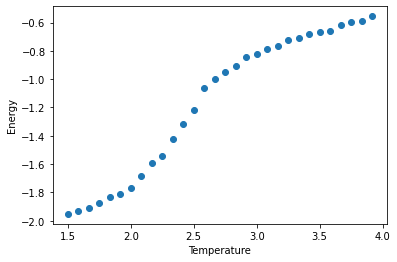

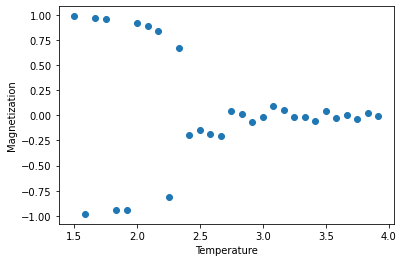

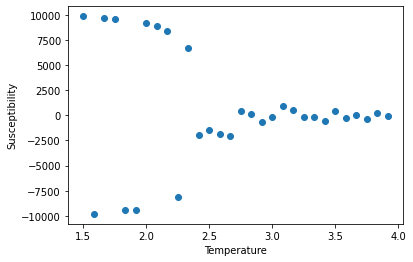

In [31]:
plot(E_avg,   E_avg2,   T, "Energy")
plot(mu_avg,  mu_avg2,  T, "Magnetization")
plot(chi_avg, chi_avg2, T, "Susceptibility")

### Plots Error Bars (errors are too significant...)

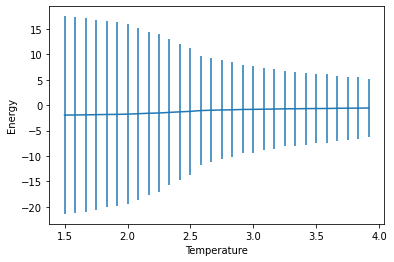

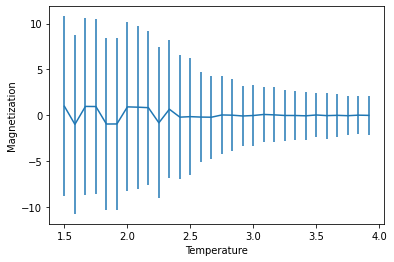

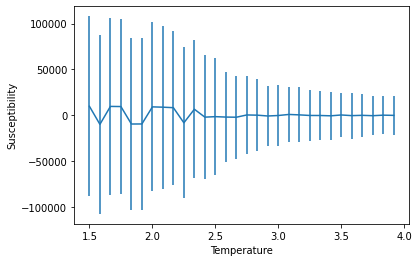

In [32]:
plot_err(E_avg,   E_avg2,   T, "Energy")
plot_err(mu_avg,  mu_avg2,  T, "Magnetization")
plot_err(chi_avg, chi_avg2, T, "Susceptibility")